# Variability
The "variability" example and exercise proposed in chapter 10 is explored.

In [1]:
import thinkbayes2
import thinkplot
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/francesco/PersonalProjects/ThinkBayes2/')
from scripts import brfss

Load the data

In [2]:
df = brfss.ReadBrfss('/Users/francesco/PersonalProjects/ThinkBayes2/data/CDBRFS08.ASC.gz')

In [3]:
df.shape

(414509, 6)

In [4]:
df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


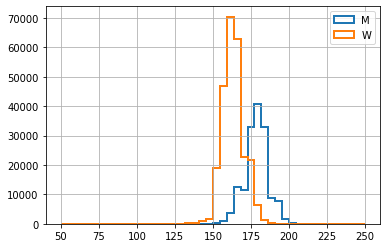

In [5]:
args = {
    'histtype': 'step',
    'linewidth': 2,
    'bins': np.linspace(50,250,45)
}

df[ df['sex']==1 ]['htm3'].hist(label='M', **args);
df[ df['sex']==2 ]['htm3'].hist(label='W', **args);
plt.legend(loc='best');

Summary statistics and coefficient of variation

In [6]:
df['sex'].replace({1: 'M', 2: 'W'}, inplace=True)

In [7]:
df['sex'].value_counts()

W    258806
M    155703
Name: sex, dtype: int64

In [8]:
grouped = df[['sex', 'htm3']].groupby('sex')
for name, group in grouped:
    m = group['htm3'].mean()
    s = group['htm3'].std()
    cv = s/m
    
    print(name, ': mean = {0:.2f}, std = {1:.2f}, cv = {2:.4f}'.format(m, s, cv))

M : mean = 178.07, std = 7.72, cv = 0.0434
W : mean = 163.22, std = 7.27, cv = 0.0445


## Mean and standard deviation
Here the focus is on the actual problem of estimating the mean and the standard deviation of the two populations. In order to do that a smaller sample is used, then the same procedure is applied to the whole dataset to check that indeed the "underflow problem" occurs.

In [9]:
df_data = df[ ~df['htm3'].isna() ].sample(n=100)

In [10]:
df_data['sex'].value_counts()

W    75
M    25
Name: sex, dtype: int64

In [11]:
data = {}
for s in df_data['sex'].unique():
    data[s] = df_data[ df_data['sex']==s ]['htm3'].values

The choice is to model the data of each cohort with a Gaussian distribution (which is legitimate) and the goal is to estimate the parameters of the Gaussians.

**step1**: set some priors on the parameters of the Gaussians. In the book both `mu` and `sigma` are assigned uniform priors, while the range is estimated directly from the data: starting from the mean and the standard deviation of the data and their standard errors, a wider interval is defined.

This is done in `variability.FindPriorRanges(...)`, but for the sake of the exercise, we redo it.

In [12]:
def MakeRange(estimate, stderr, n_points, num_stderrs=3):
    
    spread = num_stderrs * stderr
    return np.linspace(estimate-spread, estimate+spread, n_points)

def FindPriorRanges(values, n_points, num_stderrs=3):
    
    n = len(values)
    
    ### mean
    m = np.mean(values)
    m_stderr = m / math.sqrt(n)
    
    ### standard deviation
    s = np.std(values)
    s_stderr = s / math.sqrt(2*(n-1))
    
    mus = MakeRange(m, m_stderr, n_points, num_stderrs=num_stderrs)
    sigmas = MakeRange(s, s_stderr, n_points, num_stderrs=num_stderrs)
    
    return mus, sigmas

As an example, check one of the two cohorts:

In [13]:
sex = 'M'
mus, sigmas = FindPriorRanges(data[sex], 50, num_stderrs=3)
print('sex:', sex)
print(f'mus: {len(mus)} points, {np.min(mus)} --> {np.max(mus)}')
print(f'sigmas: {len(sigmas)} points, {np.min(sigmas)} --> {np.max(sigmas)}')

sex: M
mus: 50 points, 70.39999999999999 --> 281.6
sigmas: 50 points, 4.129287176168954 --> 10.436425988657547


Following the example in the book, define an `Height` class:

In [72]:
class Heigth(thinkbayes2.Suite, thinkbayes2.Joint):
    
    def __init__(self, mus, sigmas, label=None):
        '''
        init the class with uniform priors on mu and sigma
        '''
        
        pairs = [ (mu, sigma)
                for mu in mus
                for sigma in sigmas ]
        
        thinkbayes2.Suite.__init__(self, pairs, label=label)
        
    def Likelihood(self, data, hypo):
        
        height = data
        mu, sigma = hypo
        
        like = scipy.stats.norm.pdf(height, mu, sigma)
        
        return like
    
    def LogLikelihood(self, data, hypo):
        
        x = data
        mu, sigma = hypo
        
        loglike = scipy.stats.norm.logpdf(x, mu, sigma)

        return loglike

A few comments:

The uniform prior on `mu` and `sigma` is given "implicitly" by the fact that the `Suite.__init__` method is fed simply with the list of (pairs of) values. A more general approach would be to provide pdfs (or pmfs) for `mu` and `sigma` and feed `Suite.__init__` accordingly.

As usual the `Likelihood` method contains the modelling choice. As stated above the data are modelled with a Gaussian shape and for a given value of the height the question is: given the hypothesis, what is the probability of observing the given height?

Now go on and run the exercise for the two populations:

In [15]:
distr = {}

In [16]:
for sex in data.keys():
    
    mus, sigmas = FindPriorRanges(data[sex], 50, num_stderrs=3)
    
    height = Heigth(mus, sigmas, label=sex)
    
    distr[sex] = height

Check that the priors are indeed uniform

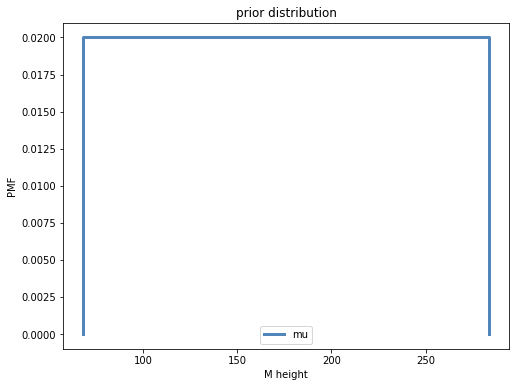

In [17]:
sex = 'M'

thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(distr[sex].Marginal(0), label='mu')
thinkplot.Config(xlabel=f'{sex} height',
                ylabel='PMF',
                title='prior distribution')

Now update with data:

**Comment**: the cell below indeed crashes because of "all probabilities are zero" already for a total sample size of 150-200 people :\

In [18]:
for sex in distr.keys():
    
    distr[sex].UpdateSet(data[sex])

Check the posteriors:

No handles with labels found to put in legend.


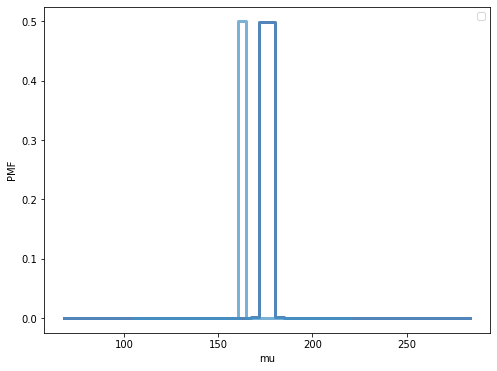

In [19]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs([distr['M'].Marginal(0), distr['W'].Marginal(0)])
thinkplot.Config(xlabel='mu',
                ylabel='PMF')

No handles with labels found to put in legend.


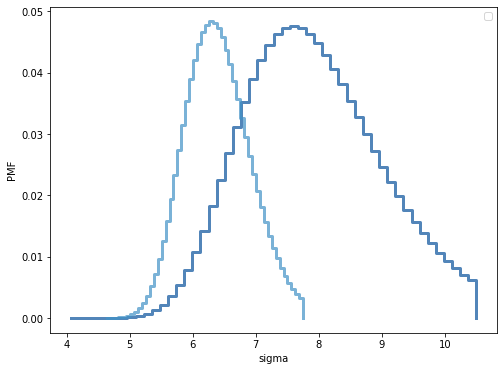

In [20]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs([distr['M'].Marginal(1), distr['W'].Marginal(1)])
thinkplot.Config(xlabel='sigma',
                ylabel='PMF')

The posterior values of the `mu`-s are very narrow, but the posterior values of the `sigma`-s are quite widely spread.

In [21]:
for sex in distr.keys():
    
    print('#####', sex)
    print('Maximum likelihood values:')
    print(distr[sex].MaximumLikelihood())

##### W
Maximum likelihood values:
(161.4504838313849, 6.288146886610703)
##### M
Maximum likelihood values:
(173.8448979591837, 7.604649378968791)


In [27]:
for sex in distr.keys():
    
    print('#####', sex)
    print('Marginal mean values:')
    print('mean:', distr[sex].Marginal(0).Mean(), ' std:', distr[sex].Marginal(1).Mean())

##### W
Marginal mean values:
mean: 162.60000000000014  std: 6.387297049615818
##### M
Marginal mean values:
mean: 176.00000000000014  std: 7.886539064190829


In [22]:
for sex in data.keys():
    m = data[sex].mean()
    s = data[sex].std()
    cv = s/m
    
    print(name, ': mean = {0:.2f}, std = {1:.2f}, cv = {2:.4f}'.format(m, s, cv))

W : mean = 162.60, std = 6.19, cv = 0.0381
W : mean = 176.00, std = 7.28, cv = 0.0414


The summary statistics of the sample are very similar to the mean of the marginal posteriors!

With the posterior distributions of `mu` and `sigma` it is possible to build the posterior distribution of the coefficient of variation `cv`

In [66]:
def getCV(height, label=None, roundTo=None):
    
    pmf = thinkbayes2.Pmf(label=label)
    
    for (mu, sigma), prob in height.Items():
        
        cv = sigma/mu
        if roundTo:
            cv = round(cv * roundTo) / roundTo
        pmf.Incr(cv, prob)
        
    pmf.Normalize()
    return pmf

In [69]:
cvs = {}
for sex in distr.keys():
    cvs[sex] = getCV(distr[sex], label=sex)

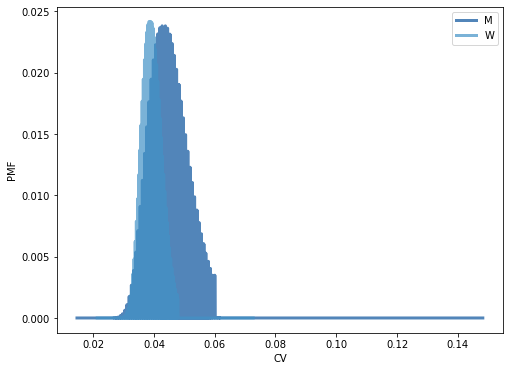

In [70]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs([cvs['M'], cvs['W']])
thinkplot.Config(xlabel='CV',
                ylabel='PMF')

## Underflow
As stated above, the step of updating the distributions with the data only works for a small sample size (< 150), and it gives errors of all the probabilities being zero above. Also the above posterior distribution of the coefficient of variation is filled with zeros and rounding the values when computing it of course reduces the precision.

Following what Allen says, it is enough to use log-transform everything in order to get rid of this problem. Let's redo the exercise with a larger sample and check. The log-related methods are added in the above definition of `Height`.

1) get the data and create the instances of `Height`

In [73]:
df_data = df[ ~df['htm3'].isna() ].sample(n=2000)

In [74]:
data = {}
for s in df_data['sex'].unique():
    data[s] = df_data[ df_data['sex']==s ]['htm3'].values

In [75]:
distr_u = {}
for sex in data.keys():
    
    mus, sigmas = FindPriorRanges(data[sex], 50, num_stderrs=3)
    
    height = Heigth(mus, sigmas, label=sex)
    
    distr_u[sex] = height

2) log-transform

In [76]:
for sex in distr_u.keys():
    
    distr_u[sex].Log()

Out of curiosity, check what the marginal prior on `mu` looks like (it is uniform in the "linear" space)

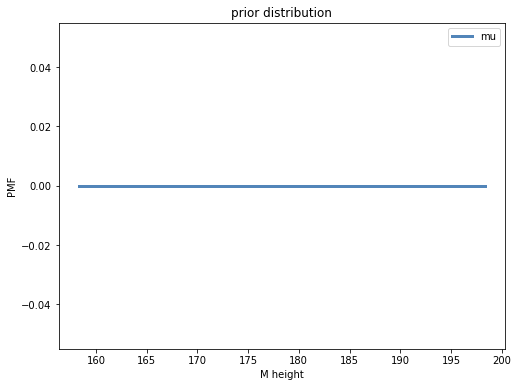

In [77]:
sex = 'M'

thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(distr_u[sex].Marginal(0), label='mu')
thinkplot.Config(xlabel=f'{sex} height',
                ylabel='PMF',
                title='prior distribution')

it is flat at 0! And it makes sense since all values are normalized to the maximum likelihood before log-transforming the distribution (which gives the maximum log-prob = 0) and in the uniform distribution all values are equal :)

3) update the log probs

In [78]:
for sex in distr_u.keys():
    distr_u[sex].LogUpdateSet(data[sex])

... it is slow indeed ...

4) take the exp of the distributions and normalize

In [79]:
for sex in distr_u.keys():
    distr_u[sex].Exp()
    distr_u[sex].Normalize()

Check the marginal/conditional posteriors

No handles with labels found to put in legend.


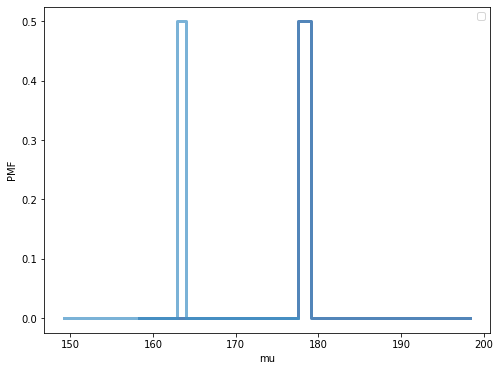

In [80]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs([distr_u['M'].Marginal(0), distr_u['W'].Marginal(0)])
thinkplot.Config(xlabel='mu',
                ylabel='PMF')

No handles with labels found to put in legend.


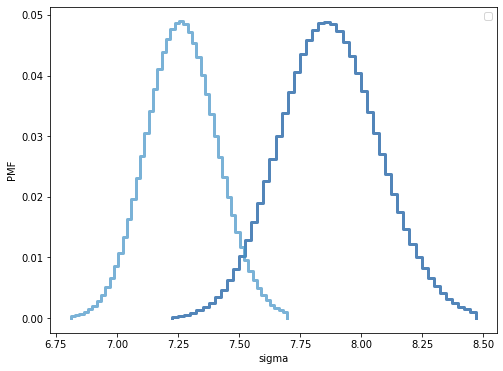

In [81]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs([distr_u['M'].Marginal(1), distr_u['W'].Marginal(1)])
thinkplot.Config(xlabel='sigma',
                ylabel='PMF')

In [82]:
cvs_u = {}
for sex in distr_u.keys():
    cvs_u[sex] = getCV(distr_u[sex], label=sex)

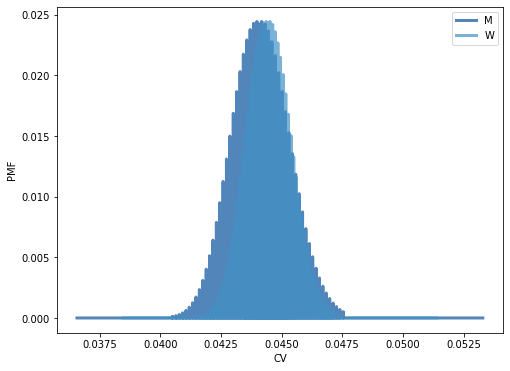

In [83]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs([cvs_u['M'], cvs_u['W']])
thinkplot.Config(xlabel='CV',
                ylabel='PMF')